In [1]:
from jax import random, vmap
import jax.numpy as np  # We need the CUDA mirror of numpy (even if we're on a CPU)

import numpyro
import numpyro.diagnostics as diag
import numpyro.distributions as dist
from numpyro import handlers
from numpyro.infer import MCMC, NUTS

devices = 3
numpyro.set_host_device_count(devices)  # Run mcmc in parallel
numpyro.enable_validation()  # Let pyro alert me to potential problems

num_warmup, num_samples = 1000, 5000
rng_key = random.PRNGKey(0)
rng_key_ = random.split(rng_key)

# Error bars as a function of increasing data uncertainty

In [2]:
m = 2.5

X = np.linspace(0, 10, 1000)
T = X * (m + .3 * random.normal(rng_key, X.shape))

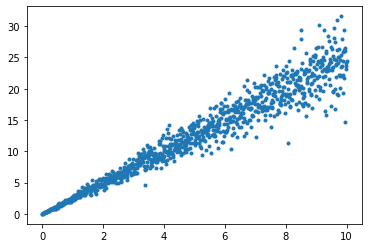

In [3]:
plt.plot(X, T, '.')

In [4]:
def model1_fn(x, t=None):
    # define non-informative priors
    w = numpyro.sample('w', dist.Normal(0, 1e6))
    var = numpyro.sample('var', dist.Exponential(1))
    std = np.sqrt(var)
    # define liklihood
    # no need for a plate, we're passing everything in at once
    mu = x * w
    return numpyro.sample('y', dist.Normal(mu, std), obs=t)

In [5]:
kernel = NUTS(model1_fn)
model1 = MCMC(kernel, num_warmup, num_samples, num_chains=1)
model1.run(rng_key, collect_warmup=False, x=X, t=T)
model1.print_summary()

sample: 100%|██████████| 6000/6000 [00:06<00:00, 983.11it/s, 3 steps of size 9.67e-01. acc. prob=0.89] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
       var      3.09      0.14      3.08      2.86      3.30   5143.27      1.00
         w      2.49      0.01      2.49      2.47      2.50   5145.95      1.00

Number of divergences: 0


We get the samples from the monte carlo method. this is effectivly the same as when we "sample the guide".

In [6]:
samples1 = model1.get_samples(group_by_chain=False)

In [7]:
w = samples1['w']
std = np.sqrt(samples1['var'])

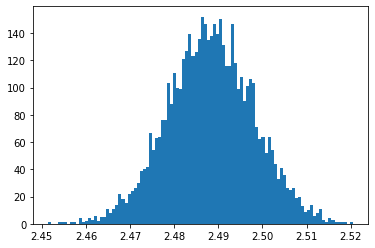

In [8]:
plt.hist(w, bins=100);

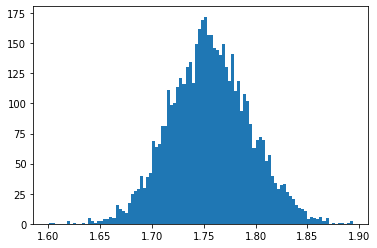

In [9]:
plt.hist(std, bins=100);

We make a prediction of 'y' for ever sample of the parameter 'w'

In [10]:
y = X[:, np.newaxis] @ w[:, np.newaxis].T
bigx = np.tile(X, (len(w), 1)).T

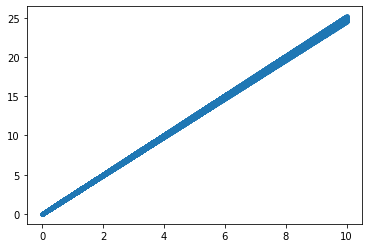

In [11]:
plt.plot(bigx.ravel(), y.ravel(), '.');

In [12]:
y_mean = y.mean(axis=1)
y_std = y.std(axis=1)
y_99 = diag.hpdi(y, .99, axis=1)  # 99th percentile

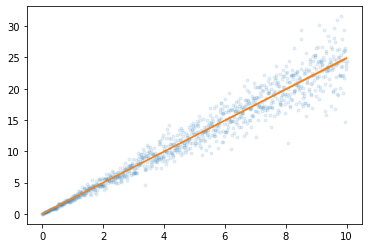

In [13]:
plt.plot(X, T, '.', alpha=.1)
plt.plot(X, y_mean)
plt.fill_between(X, y_mean - y_std, y_mean + y_std, alpha=.9)
plt.fill_between(X, y_99[:, 0], y_99[:, 1], alpha=.5)

For ever data point the model predicted, there was an uncertainty associated with that. This is the `var` term. This is what we get back when we querry `obs` in the other model

In [14]:
y_obs = y + std.mean() * random.normal(rng_key, shape=y.shape)

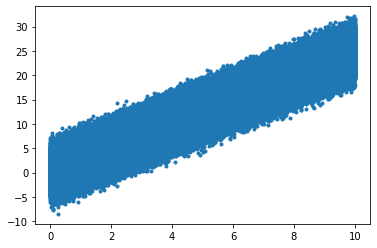

In [15]:
plt.plot(bigx.ravel(), y_obs.ravel(), '.');

In [16]:
y_obs_mean = y_obs.mean(axis=1)
y_obs_std = y_obs.std(axis=1)
y_obs_99 = diag.hpdi(y_obs, .99, axis=1)  # 99th percentile

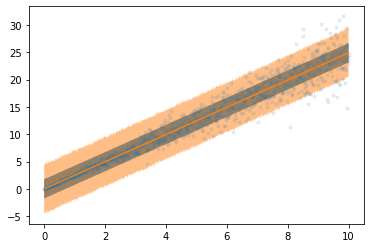

In [17]:
plt.plot(X, T, '.', alpha=.1)
plt.plot(X, y_mean)
plt.fill_between(X, y_obs_mean - y_obs_std, y_obs_mean + y_obs_std, alpha=.9)
plt.fill_between(X, y_obs_99[:, 0], y_obs_99[:, 1], alpha=.5)

We can use pyros built in functionality to do this also. This effecivly makes a predion using the `model`.
Note the parameters for the distribution, I subsitute in the parameters found (see the model summary above)


    def model_fn(x):    <---------- we pass in the `x` value we want to make a prediction on. 
        # we generate a random w
        w = numpyro.sample('w', dist.Normal(2.5, 0.14))
        
        # Using that mu, we make a predition
        mu = x * w
        
        # During training, we've seen we've been wrong, we generate another
        # sample +/- our "confedence". But note that this is independent of x
        return numpyro.sample('y', dist.Normal(mu, np.sqrt(3.00))) 

In [18]:
from numpyro.infer import Predictive

predictive = Predictive(model1_fn, samples1)  # Use our model and the 'guide' samples
predictions = predictive.get_samples(rng_key, x=X)['y']  # get back the values generated by the normal distribution 'y'

In [19]:
pred_mean = np.mean(predictions, axis=0)
pred_std = np.std(predictions, axis=0)
hpdi_pred = diag.hpdi(predictions, 0.99)

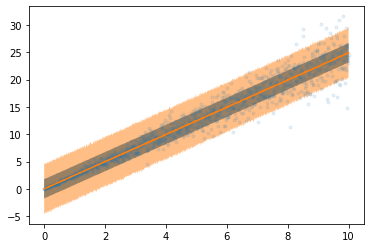

In [20]:
plt.plot(X, T, '.', alpha=.1)
plt.plot(X, pred_mean)
plt.fill_between(X, pred_mean - pred_std, pred_mean + pred_std, alpha=.9)
plt.fill_between(X, hpdi_pred[0], hpdi_pred[1], alpha=0.5)

# Error bars as a function of data sparcity

If we were to do something different, like fit the above model with sparce data. Our error bars would be the same

In [21]:
m = 2.5

# Make data more sparse at higher numbers
X = np.logspace(0, 3, 100) / 1e2
T = X * m

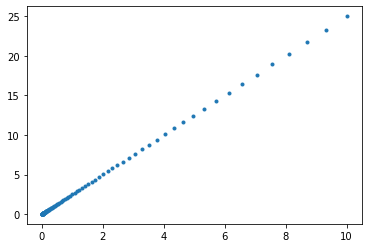

In [22]:
plt.plot(X, T, '.')

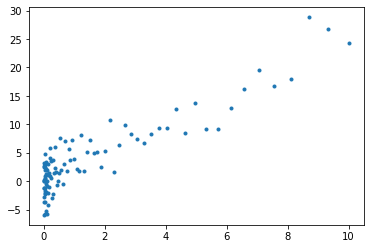

In [23]:
# add some uniform random noise
# or multiplicitive noise, as above
T = T + 3 * random.normal(rng_key, shape=T.shape)
# T = T + .3 * X * random.normal(rng_key, shape=T.shape)
plt.plot(X, T, '.')

In [24]:
kernel = NUTS(model1_fn)
model1_sparse = MCMC(kernel, num_warmup, num_samples, num_chains=1)
model1_sparse.run(rng_key, collect_warmup=False, x=X, t=T)
model1_sparse.print_summary()

sample: 100%|██████████| 6000/6000 [00:05<00:00, 1042.92it/s, 7 steps of size 7.42e-01. acc. prob=0.94]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
       var      7.31      0.94      7.24      5.76      8.78   3336.79      1.00
         w      2.54      0.10      2.54      2.37      2.71   3125.36      1.00

Number of divergences: 0


In [25]:
samples_sparse = model1.get_samples(group_by_chain=False)
predictive = Predictive(model1_fn, samples_sparse)  # Use our model and the 'guide' samples
predictions = predictive.get_samples(rng_key, x=X)['y']  # get back the values generated by the normal distribution 'y'

In [26]:
pred_mean = np.mean(predictions, axis=0)
pred_std = np.std(predictions, axis=0)
hpdi_pred = diag.hpdi(predictions, 0.99)

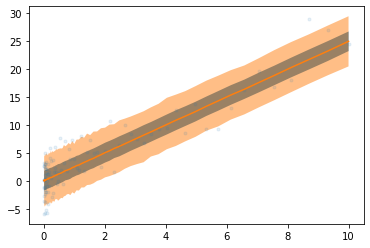

In [27]:
plt.plot(X, T, '.', alpha=.1)
plt.plot(X, pred_mean)
plt.fill_between(X, pred_mean - pred_std, pred_mean + pred_std, alpha=.9)
plt.fill_between(X, hpdi_pred[0], hpdi_pred[1], alpha=0.5)

# Error bars as a function of free parameters

Where we start to see this change is when we enter more degrees of freedom into the model.

In [28]:
m = 2.5

X = 5 + 2 * random.normal(rng_key, (10,))  # randomaly generate X values so theyr sparce
X = X.sort()
T = X * m + 3 * random.normal(rng_key, shape=X.shape)

Now the model doesn't have a clear intercept or slope

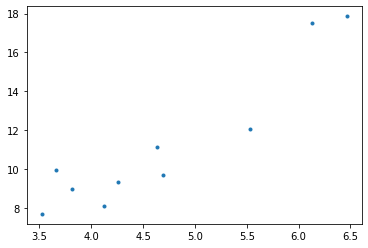

In [29]:
plt.plot(X, T, '.')

In [30]:
def model2_fn(x, t=None):
    # define non-informative priors
    w = numpyro.sample('w', dist.Normal(0, 1e6))
    b = numpyro.sample('b', dist.Normal(0, 1e6))
    
    var = numpyro.sample('var', dist.Exponential(1))
    std = np.sqrt(var)
    
    # define liklihood
    # no need for a plate, we're passing everything in at once
    mu = x * w + b
    return numpyro.sample('y', dist.Normal(mu, std), obs=t)

In [31]:
kernel = NUTS(model2_fn)
model2_sparse = MCMC(kernel, num_warmup, num_samples, num_chains=1)
model2_sparse.run(rng_key, collect_warmup=False, x=X, t=T)
model2_sparse.print_summary()

sample: 100%|██████████| 6000/6000 [00:05<00:00, 1101.35it/s, 15 steps of size 1.12e-01. acc. prob=0.95]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         b     -4.15      2.02     -4.16     -7.50     -0.74   1519.27      1.00
       var      1.89      0.79      1.72      0.79      2.97   1664.85      1.00
         w      3.28      0.42      3.29      2.54      3.94   1511.33      1.00

Number of divergences: 0


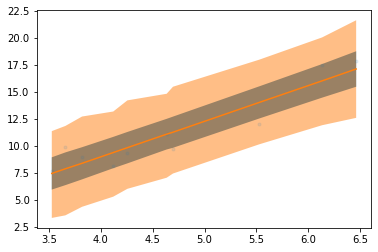

In [32]:
samples2 = model2_sparse.get_samples()
predictive = Predictive(model2_fn, samples2)
predictions = predictive.get_samples(rng_key, x=X)['y']

pred_mean = np.mean(predictions, axis=0)
pred_std = np.std(predictions, axis=0)
hpdi_pred = diag.hpdi(predictions, 0.99)

plt.plot(X, T, '.', alpha=.1)
plt.plot(X, pred_mean)
plt.fill_between(X, pred_mean - pred_std, pred_mean + pred_std, alpha=.9)
plt.fill_between(X, hpdi_pred[0], hpdi_pred[1], alpha=0.5)

At this point it looks the same, but if we increase our prediction range, we see the error due to the intercept come in

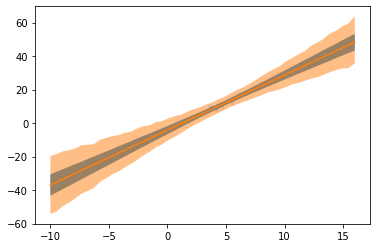

In [33]:
# Increase the prediction range
XX = np.linspace(-10, 16)

predictions = predictive.get_samples(rng_key, x=XX)['y']

pred_mean = np.mean(predictions, axis=0)
pred_std = np.std(predictions, axis=0)
hpdi_pred = diag.hpdi(predictions, 0.99)

plt.plot(X, T, '.', alpha=.1)
plt.plot(XX, pred_mean)
plt.fill_between(XX, pred_mean - pred_std, pred_mean + pred_std, alpha=.9)
plt.fill_between(XX, hpdi_pred[0], hpdi_pred[1], alpha=0.5)

If we run the same data as we did at the start of the post. That uncertainty goes away, because the data does a good job of defining the intercept and slope

In [34]:
m = 2.5

X = np.linspace(0, 10, 1000)
T = X * (m + .3 * random.normal(rng_key, X.shape))

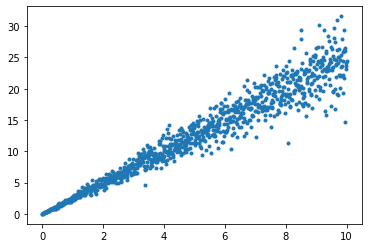

In [35]:
plt.plot(X, T, '.')

In [36]:
kernel = NUTS(model2_fn)
model2 = MCMC(kernel, num_warmup, num_samples, num_chains=1)
model2.run(rng_key, collect_warmup=False, x=X, t=T)
model2.print_summary()
samples2 = model2.get_samples()

sample: 100%|██████████| 6000/6000 [00:06<00:00, 952.39it/s, 15 steps of size 3.25e-01. acc. prob=0.94] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         b      0.08      0.11      0.08     -0.10      0.26   2478.50      1.00
       var      3.08      0.14      3.08      2.86      3.31   2478.28      1.00
         w      2.48      0.02      2.48      2.45      2.51   2550.30      1.00

Number of divergences: 0


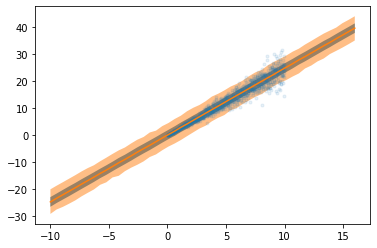

In [37]:
XX = np.linspace(-10, 16)

predictive = Predictive(model2_fn, samples2)
predictions = predictive.get_samples(rng_key, x=XX)['y']

pred_mean = np.mean(predictions, axis=0)
pred_std = np.std(predictions, axis=0)
hpdi_pred = diag.hpdi(predictions, 0.99)

plt.plot(X, T, '.', alpha=.1)
plt.plot(XX, pred_mean)
plt.fill_between(XX, pred_mean - pred_std, pred_mean + pred_std, alpha=.9)
plt.fill_between(XX, hpdi_pred[0], hpdi_pred[1], alpha=0.5)